In [1]:
%matplotlib inline
import os
import shutil
import numpy as np

import tensorflow as tf
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

np.random.seed(30)
tf.random.set_random_seed(30)
LOG_DIR = "./logs/"
if os.path.exists(LOG_DIR):
    shutil.rmtree(LOG_DIR)
os.makedirs(LOG_DIR,exist_ok=True)

## 데이터 셋

이번에는 데이터가 매우 많은 상황 속에 놓여져 있다.
이 상황을 느끼기 위해서는, Colab의 GPU 기능을 끄고, CPU로 연산을 돌려보는 것을 추천한다. GPU는 병렬로 처리하기 때문에, 이슈가 발생하려면, 데이터가 훨씬 더 많이 필요하다. 

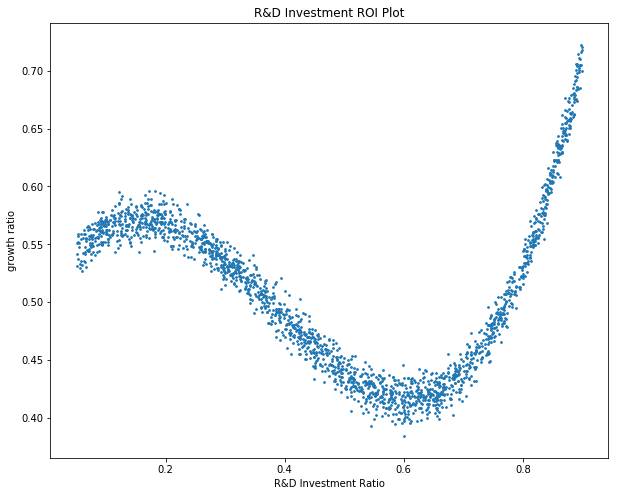

In [2]:
random_polynomial = lambda x : 3.5*x**3-4*x**2+x+0.5

invests = np.random.uniform(0.05,0.9, 2000) # 5% ~ 90% 까지 기술 투자 비율
growths = np.array([random_polynomial(x)+np.random.normal(0,0.01) 
           for x in invests]) # 예상 수익률

plt.figure(figsize=(10,8))
plt.scatter(invests, growths, s=3)
plt.title("R&D Investment ROI Plot")
plt.xlabel("R&D Investment Ratio")
plt.ylabel("growth ratio")
plt.show()

invests = invests.reshape(-1,1) # (data_nums, feature_nums) => (1000, 1)
growths = growths.reshape(-1,1) # (data_nums, target_nums) => (1000, 1)

## 학습 데이터 셋과 평가 데이터셋 분리

In [3]:
# index를 생성하여, 순서를 섞음
idx = np.arange(len(invests))
np.random.shuffle(idx) 

# 학습 데이터셋 : 평가 데이터셋 = 7:3
train_nums = int(len(invests) * 0.7)
train_idx, test_idx = idx[:train_nums], idx[train_nums:]

# 데이터 셋 분리
train_invests, train_growths = invests[train_idx], growths[train_idx]
test_invests, test_growths = invests[test_idx], growths[test_idx]

### 학습 모델

이전 실습에서 다루었던 모델.

In [4]:
num_unit_1 = 100 # 1번째 은닉층 unit 수
num_unit_2 = 100 # 2번째 은닉층 unit 수

graph = tf.Graph()
with graph.as_default():
    X = tf.placeholder(tf.float32, shape=(None,1),name='X')
    y = tf.placeholder(tf.float32, shape=(None,1),name='y')
    
    # Weight 초기화 함수
    weight_initializer = tf.initializers.truncated_normal()
    
    # Graph 부분
    hidden_1 = tf.layers.dense(X, num_unit_1, activation=tf.nn.sigmoid,
                               kernel_initializer=weight_initializer, name="hidden_1")
    hidden_2 = tf.layers.dense(hidden_1, num_unit_2, activation=tf.nn.sigmoid, 
                               kernel_initializer=weight_initializer, name='hidden_2')
    y_pred = tf.layers.dense(hidden_2, 1,
                            kernel_initializer=weight_initializer, name='output')
    
    # 손실 함수
    loss = tf.losses.mean_squared_error(y, y_pred)
    
    # 성능 지표
    with tf.variable_scope('metric'):
        rmse = tf.sqrt(loss, name='rmse')

    # Summary
    tf.summary.histogram("hidden-1-Weight", 
                         graph.get_tensor_by_name('hidden_1/kernel:0'))
    tf.summary.histogram("hidden-2-Weight", 
                         graph.get_tensor_by_name('hidden_2/kernel:0'))
    tf.summary.histogram("output-Weight", 
                         graph.get_tensor_by_name('output/kernel:0'))
    tf.summary.scalar("rmse", rmse)
    
    # training operation
    train_op = (tf.train
                .GradientDescentOptimizer(learning_rate=0.01)
                .minimize(loss))

### 학습

 0th epoch RMSE : 3.425
1000th epoch RMSE : 0.051
2000th epoch RMSE : 0.047
3000th epoch RMSE : 0.045
4000th epoch RMSE : 0.044
5000th epoch RMSE : 0.043
6000th epoch RMSE : 0.042
7000th epoch RMSE : 0.041
8000th epoch RMSE : 0.040
9000th epoch RMSE : 0.039
10000th epoch RMSE : 0.038
11000th epoch RMSE : 0.037
학습 총 소요 시간 ---- 23.714s


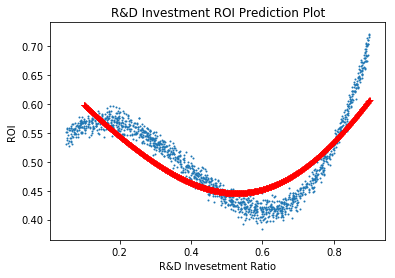

In [5]:
# 학습
n_epoch = 12000

start_time = time.time() # 현재 시간 가져오기
with tf.Session(graph=graph) as sess:
    # 가중치 초기화
    init = tf.global_variables_initializer()
    sess.run(init)
    
    # Summary op
    summary_op = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(LOG_DIR+"regression_with_full_dataset/train/")
    test_writer = tf.summary.FileWriter(LOG_DIR+"regression_with_full_dataset/test/")
    
    for epoch in range(n_epoch):
        # 학습
        sess.run(train_op,feed_dict={X:train_invests,
                                     y:train_growths})
        
        if epoch % 50 == 0:
            # 100 Epoch 마다 저장 Tensorboard에 Summary Value 저장
            ## Train 
            summary_str = sess.run(summary_op, feed_dict={
                X: train_invests, y:train_growths
            })
            train_writer.add_summary(summary_str, global_step=epoch)
            ## Test
            summary_str,rmse_value = sess.run([summary_op,rmse], 
                          feed_dict={X: test_invests, y:test_growths})
            test_writer.add_summary(summary_str, global_step=epoch)            
            if epoch % 1000 == 0:
                print("{:2d}th epoch RMSE : {:2.3f}".format(epoch, 
                                                        rmse_value))
                
    # 0부터 1까지 순서대로 1000개를 출력
    test_xs = np.linspace(0.1,0.9,1000)
    test_xs = test_xs.reshape(-1,1)
    pred_ys = sess.run(y_pred, feed_dict={X:test_xs})

consumed_time = time.time() - start_time # 학습에 총 걸린 시간
print(f"학습 총 소요 시간 ---- {consumed_time:.3f}s")
    
plt.scatter(train_invests, train_growths, s=1)
plt.plot(test_xs,pred_ys,'r+')
plt.title("R&D Investment ROI Prediction Plot")
plt.xlabel("R&D Invesetment Ratio")
plt.ylabel("ROI")
plt.show()

Data가 많으니 학습시간이 매우 지연이 된다. 대신 데이터를 하나씩 넣어서 돌려보자

## SGD(stochastic Gradient Descent)

    0 epoch RMSE : 0.059
    1 epoch RMSE : 0.055
    2 epoch RMSE : 0.052
    3 epoch RMSE : 0.049
    4 epoch RMSE : 0.046
    5 epoch RMSE : 0.044
    6 epoch RMSE : 0.042
    7 epoch RMSE : 0.040
    8 epoch RMSE : 0.038
    9 epoch RMSE : 0.037
학습 총 소요 시간 ---- 4.712s


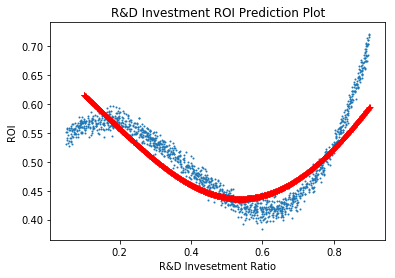

In [6]:
# 학습
n_epoch = 10

start_time = time.time() # 현재 시간 가져오기
with tf.Session(graph=graph) as sess:
    # 가중치 초기화
    init = tf.global_variables_initializer()
    sess.run(init)
    
    # Summary op
    summary_op = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(LOG_DIR+"regression_with_one_dataset/train/")
    test_writer = tf.summary.FileWriter(LOG_DIR+"regression_with_one_dataset/test/")
    
    global_step = 0
    for epoch in range(n_epoch):
        for step in range(len(train_invests)):
            # 학습
            global_step += 1
            sess.run(train_op,feed_dict={X:train_invests[step:step+1],
                                         y:train_growths[step:step+1]})

            if step % 100 == 0:
                ## Train 
                summary_str = sess.run(summary_op, feed_dict={
                    X: train_invests, y:train_growths})
                train_writer.add_summary(summary_str,
                                         global_step=global_step)

        ## Test
        summary_str,rmse_value = sess.run([summary_op,rmse], 
                      feed_dict={X: test_invests, y:test_growths})
        test_writer.add_summary(summary_str, 
                                global_step=global_step)                
        print(f"{epoch:5d} epoch RMSE : {rmse_value:2.3f}")
            
    # 0부터 1까지 순서대로 1000개를 출력
    test_xs = np.linspace(0.1,0.9,1000)
    test_xs = test_xs.reshape(-1,1)
    pred_ys = sess.run(y_pred, feed_dict={X:test_xs})

consumed_time = time.time() - start_time # 학습에 총 걸린 시간
print(f"학습 총 소요 시간 ---- {consumed_time:.3f}s")
    
plt.scatter(train_invests, train_growths, s=1)
plt.plot(test_xs,pred_ys,'r+')
plt.title("R&D Investment ROI Prediction Plot")
plt.xlabel("R&D Invesetment Ratio")
plt.ylabel("ROI")
plt.show()

## Mini-Batch SGD(stochastic Gradient Descent)

    0 epoch step RMSE : 0.140
   10 epoch step RMSE : 0.060
   20 epoch step RMSE : 0.054
   30 epoch step RMSE : 0.050
   40 epoch step RMSE : 0.046
학습 총 소요 시간 ---- 5.302s


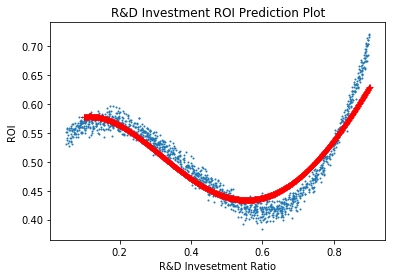

In [7]:
# 학습
n_epoch = 50
batch_size = 5

start_time = time.time() # 학습 시작 시간
with tf.Session(graph=graph) as sess:
    # 가중치 초기화
    init = tf.global_variables_initializer()
    sess.run(init)
    
    # Summary op
    summary_op = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(LOG_DIR+"regression_with_batch_dataset/train/")
    test_writer = tf.summary.FileWriter(LOG_DIR+"regression_with_batch_dataset/test/")
    
    global_step = 0
    for epoch in range(n_epoch):
        for step in range(len(train_invests)//batch_size):
            # 학습
            global_step += 1
            sess.run(train_op,feed_dict={X:train_invests[step*batch_size:(step+1)*batch_size],
                                         y:train_growths[step*batch_size:(step+1)*batch_size]})

            if step % 100 == 0:
                ## Train
                summary_str = sess.run(summary_op, feed_dict={
                    X: train_invests, y:train_growths})
                train_writer.add_summary(summary_str,
                                         global_step=global_step)

                ## Test
                summary_str,rmse_value = sess.run([summary_op,rmse], 
                              feed_dict={X: test_invests, y:test_growths})
                test_writer.add_summary(summary_str, 
                                        global_step=global_step)            
                
        if epoch % 10 == 0:
            print(f"{epoch:5d} epoch step RMSE : {rmse_value:2.3f}")
            
    # 0부터 1까지 순서대로 1000개를 출력
    test_xs = np.linspace(0.1,0.9,1000)
    test_xs = test_xs.reshape(-1,1)
    pred_ys = sess.run(y_pred, feed_dict={X:test_xs})

consumed_time = time.time() - start_time # 학습에 총 걸린 시간
print(f"학습 총 소요 시간 ---- {consumed_time:.3f}s")
    
plt.scatter(train_invests, train_growths, s=1)
plt.plot(test_xs,pred_ys,'r+')
plt.title("R&D Investment ROI Prediction Plot")
plt.xlabel("R&D Invesetment Ratio")
plt.ylabel("ROI")
plt.show()